In [26]:
import sys
from pathlib import Path

# point Python at the project `src/` tree so imports work
ROOT = Path().resolve().parents[0]
sys.path.append(str(ROOT / "src"))

import numpy as np
import matplotlib.pyplot as plt
from parser import ParseRespDotOut, ParseDotXYZ

plt.style.use("rotskoff_notebook.mplstyle")

BOHR_PER_ANG = 1.8897261254578281  # handy if you expand later

In [27]:
from collections import Counter

RESP_OUT = ROOT / "data" / "raw" / "resp.out"
GEOM_XYZ = ROOT / "data" / "raw" / "1.pose.xyz"
N_ATOMS = 78  # adjust per system

xyz_frames = ParseDotXYZ(GEOM_XYZ).elements()
if not xyz_frames:
    raise RuntimeError("No frames located in geometry xyz file.")

element_labels = xyz_frames[0].symbols
if len(element_labels) != N_ATOMS:
    raise RuntimeError("XYZ element count does not match N_ATOMS.")

# Build atom keys like N1, N2, O1, ...
atom_keys = []
counters = Counter()
for symbol in element_labels:
    counters[symbol] += 1
    tag = f"{symbol}{counters[symbol]}"
    atom_keys.append(tag)

parser = ParseRespDotOut(RESP_OUT, N_ATOMS)
frames = parser.extract_frames()
if not frames:
    raise RuntimeError("No ESP-unrestrained frames parsed from resp.out.")

charges_per_atom = {key: [] for key in atom_keys if key.startswith(("N", "O"))}

for frame in frames:
    charges = np.asarray(frame.esp_charges, dtype=float)
    for idx, key in enumerate(atom_keys):
        if key in charges_per_atom:
            charges_per_atom[key].append(charges[idx])

# Convert to numpy arrays and report counts
for key, values in charges_per_atom.items():
    charges_per_atom[key] = np.asarray(values, dtype=float)

print("Nitrogen atoms:", [k for k in charges_per_atom if k.startswith("N")])
print("Oxygen atoms:", [k for k in charges_per_atom if k.startswith("O")])

Nitrogen atoms: ['N1', 'N2', 'N3', 'N4']
Oxygen atoms: ['O1', 'O2', 'O3', 'O4', 'O5', 'O6']


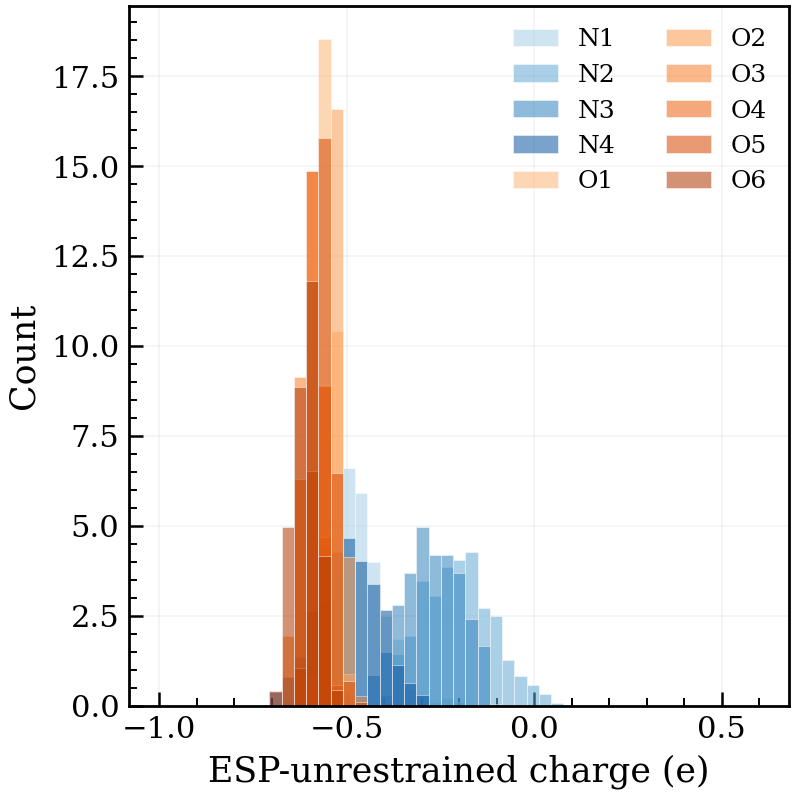

In [69]:
fig, ax = plt.subplots(figsize=(4, 4))

nitrogen_keys = [k for k in charges_per_atom if k.startswith("N")]
oxygen_keys   = [k for k in charges_per_atom if k.startswith("O")]

# color palettes for N and O
colors_n = plt.cm.Blues(np.linspace(0.35, 0.85, len(nitrogen_keys)))
colors_o = plt.cm.Oranges(np.linspace(0.35, 0.85, len(oxygen_keys)))

bins = np.linspace(-1.0, 0.6, 50)

for color, key in zip(colors_n, nitrogen_keys):
    ax.hist(
        charges_per_atom[key],
        bins=bins,
        alpha=0.55,
        label=f"{key}",
        color=color,
        edgecolor="white",
        linewidth=0.3,
        density=True,
    )

for color, key in zip(colors_o, oxygen_keys):
    ax.hist(
        charges_per_atom[key],
        bins=bins,
        alpha=0.55,
        label=f"{key}",
        color=color,
        edgecolor="white",
        linewidth=0.3,
        density=True,
    )

ax.set_xlabel("ESP-unrestrained charge (e)")
ax.set_ylabel("Count")
ax.legend(ncol=2, fontsize=9, frameon=False)
ax.grid(alpha=0.3)

#plt.show()

# Vector (best for papers)
#fig.savefig("raw_esp.pdf", bbox_inches="tight", pad_inches=0.02,
            #metadata={"Title": "Raw ESP", "Author": "Lefteris Mainas"})

# High-res raster (best for slides)
fig.savefig("../reports/raw_esp.png", dpi=600, bbox_inches="tight")
plt.savefig("../docs/img/raw_esp.png")

# Optional: editable vector for Illustrator/Inkscape
#fig.savefig("raw_esp.svg", bbox_inches="tight", pad_inches=0.02)


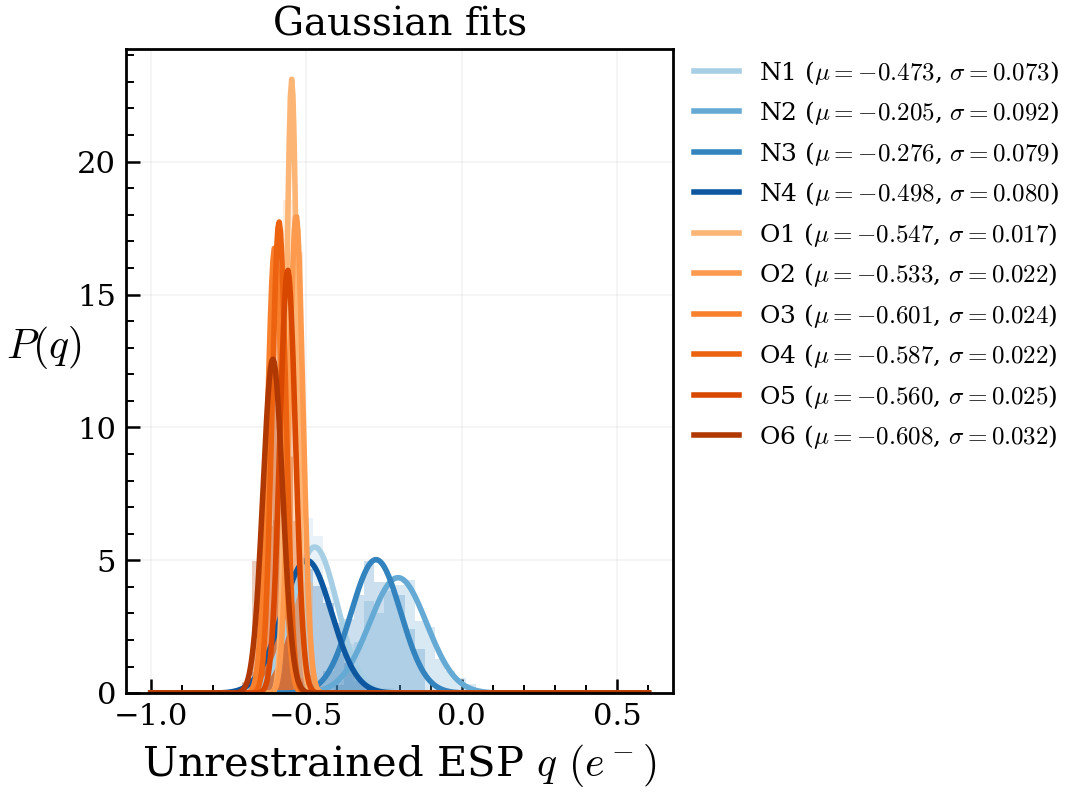

In [68]:
from scipy.stats import norm

fig, ax = plt.subplots(figsize=(4, 4))
fig.set_size_inches(5.4, 4)  # make the figure a bit wider to fit the outside legend

for color, key in zip(colors_n, nitrogen_keys):
    data = charges_per_atom[key]
    counts, bin_edges, _ = ax.hist(
        data,
        bins=bins,
        density=True,
        alpha=0.25,
        color=color,
        edgecolor="none",
    )
    mean, sigma = data.mean(), data.std(ddof=1)
    x = np.linspace(bin_edges[0], bin_edges[-1], 400)
    ax.plot(x, norm.pdf(x, mean, sigma), color=color, linewidth=2.0,
            label=fr"{key} ($\mu={mean:.3f}$, $\sigma={sigma:.3f}$)")

for color, key in zip(colors_o, oxygen_keys):
    data = charges_per_atom[key]
    counts, bin_edges, _ = ax.hist(
        data,
        bins=bins,
        density=True,
        alpha=0.25,
        color=color,
        edgecolor="none",
    )
    mean, sigma = data.mean(), data.std(ddof=1)
    x = np.linspace(bin_edges[0], bin_edges[-1], 400)
    ax.plot(x, norm.pdf(x, mean, sigma), color=color, linewidth=2.0,
            label=fr"{key} ($\mu={mean:.3f}$, $\sigma={sigma:.3f}$)")

ax.set_xlabel(fr"Unrestrained ESP $q$ $(e^-)$", fontsize=15)
ax.set_ylabel(fr"$P (q)$", rotation=0, labelpad=12, fontsize=15)
ax.set_title("Gaussian fits")

ax.legend(fontsize=9, frameon=False, ncol=1, loc='upper left',
          bbox_to_anchor=(1.02, 1.0), borderaxespad=0.0)

ax.grid(alpha=0.3)
#plt.show()

# Vector (best for papers)
#fig.savefig("gaussian_fits.pdf", bbox_inches="tight", pad_inches=0.02,
            #metadata={"Title": "Gaussian fits", "Author": "Lefteris Mainas"})

# High-res raster (best for slides)
fig.savefig("../reports/gaussian_fits.png", dpi=600, bbox_inches="tight")
plt.savefig("../docs/img/gaussian_fits.png")

# Optional: editable vector for Illustrator/Inkscape
#fig.savefig("gaussian_fits.svg", bbox_inches="tight", pad_inches=0.02)